**BEM-VINDO!**

Inicialmente, devemos esclarecer que, por mais que seu significa a princípio esteja ligado à consumidores, durante esse código utilizaremos o termo "churn" como definição para a saída precoce de um atleta da NBA, sendo precoce uma atuação em anos inferior à média da década.

Este código utilizará como referência o medium: https://medium.com/neuronio-br/como-criar-um-modelo-para-predi%C3%A7%C3%A3o-de-churn-aa11b9feb8a6

In [210]:
# Importando as bibliotecas necessárias:

import numpy as np
import pandas as pd

import math
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, log_loss
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [211]:
# O path contém o caminho para o arquivo CSV que você deseja ler.
path = '/content/combined.csv'

# pd.read_csv é usado para ler o arquivo CSV localizado no caminho especificado e armazená-lo em um DataFrame pandas chamado df.
# Um DataFrame é uma estrutura de dados bidimensional com rótulos de coluna, semelhante a uma tabela em um banco de dados SQL ou uma planilha do Excel.
df = pd.read_csv(path)

In [212]:
# Exibindo informações detalhadas sobre o DataFrame 'df':
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2294 entries, 0 to 2293
Data columns (total 25 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Player       2294 non-null   object 
 1   careers      2294 non-null   int64  
 2   Pos          2294 non-null   object 
 3   Tm           2294 non-null   object 
 4   G            2294 non-null   int64  
 5   PER          2294 non-null   float64
 6   GS           2294 non-null   int64  
 7   MP           2294 non-null   int64  
 8   TS           2294 non-null   float64
 9   OWS          2294 non-null   float64
 10  DWS          2294 non-null   float64
 11  WS           2294 non-null   float64
 12  BPM          2294 non-null   float64
 13  FG           2294 non-null   float64
 14  P2           2294 non-null   float64
 15  P3           2294 non-null   float64
 16  year_start   2294 non-null   int64  
 17  year_end     2294 non-null   int64  
 18  height       2294 non-null   object 
 19  weight

In [213]:
# Exibindo as primeiras cinco linhas do DataFrame 'df' para obter uma visualização rápida dos dados.
df.head()

,Player,careers,Pos,Tm,G,PER,GS,MP,TS,OWS,...,P3,year_start,year_end,height,weight,birth_date,year_active,age_start,age_end,churn
0,A.C. Green,18,PF,MIA,1361,13.9,905,39044,0.5,3.4,...,0.1,1986,2001,6-9,220,1963,16,23,38,0
1,A.J. English,2,SG,WSB,151,11.6,18,3108,0.5,-0.2,...,0.1,1991,1992,6-3,175,1967,2,24,25,1
2,A.J. Guyton,3,PG,GSW,80,4.4,14,1246,0.3,0.1,...,0.3,2001,2003,6-1,180,1978,3,23,25,1
3,A.J. Hammons,1,C,DAL,22,8.4,0,163,0.5,-0.2,...,0.5,2017,2017,7-0,260,1992,1,25,25,1
4,A.J. Price,9,PG,PHO,287,10.4,25,4253,0.4,0.1,...,0.2,2010,2015,6-2,181,1986,6,24,29,0


#O dataset não contem valores nulos


In [214]:
# Atribuindo o número total de linhas (ou entradas) no DataFrame 'df' à variável 'total'.
total = len(df)

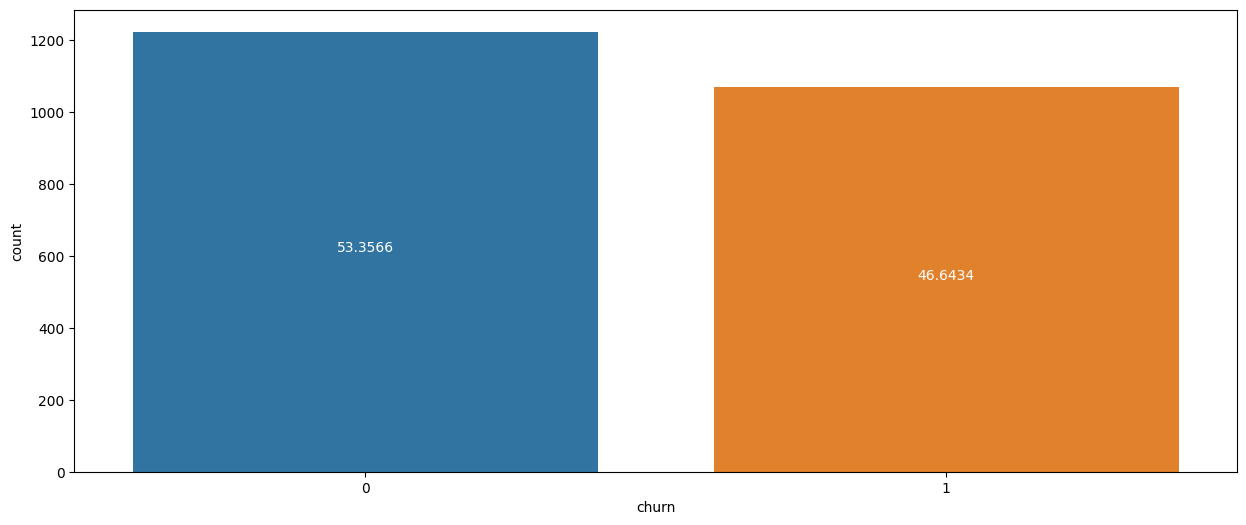

In [215]:
fig, ax = plt.subplots(figsize=(15,6)) # Iniciando uma figura e um eixo com um tamanho específico de 15 por 6 polegadas.

g = sns.countplot(data=df, x='churn') # Criando um gráfico de barras para a distribuição da coluna 'churn' do DataFrame 'df'.

for p in g.patches: # Looping por cada barra (ou patch) no gráfico para adicionar texto.
    height = p.get_height()  # Obtendo a altura da barra (quantidade representada pela barra).
    # Adicionando um texto à barra. O texto é a porcentagem da quantidade da barra em relação ao total.
    # O texto é posicionado no centro da barra e na metade da sua altura.
    g.text(p.get_x()+p.get_width()/2.,
            height/2,
            '{:1.4f}'.format(100*height/total),  # Formatação do texto para mostrar 4 casas decimais.
            ha="center", color='white')

plt.savefig('Churn_distribution.png') # Em vez de mostrar o gráfico usando plt.show(), ele salva a figura como 'Churn_distribution.png'.

# Modelo de implementação



In [216]:
df['GS_mean'] = df['GS'] / df['G']  # Transformando Número de Jogos e Número de Jogos como principal em um razão, pois julgo que essas informações dão a resposta ao modelo, já que números de jogos alto indicam que o atleta atua há muito tempo. Se aplicassemos esse modelo treinado com essas informações, ele poderia classificar atletas de início de carreira (com poucos jogos) como churn de forma errônea.
df['MP_mean'] = df['MP'] / df['G']

In [217]:
df = df.drop(["G","GS", "MP"], axis = 1) # Removendo colunas que tenham relação direta com o tempo de dedicação total ao basquete
df = df.drop(["Player"], axis = 1) # Removendo colunas de nomes, pois não agregam  atrapalham o modelo
df = df.drop(["year_start","year_end", "year_active", "age_end", "birth_date"], axis = 1) # Removendo coluna que foram utilizadas para definir churn ou que de certa forma poderiam ser utilizadas

In [218]:
df.head()

,careers,Pos,Tm,PER,TS,OWS,DWS,WS,BPM,FG,P2,P3,height,weight,age_start,churn,GS_mean,MP_mean
0,18,PF,MIA,13.9,0.5,3.4,2.4,5.8,-0.1,0.5,0.5,0.1,6-9,220,23,0,0.664952,28.687730
1,2,SG,WSB,11.6,0.5,-0.2,0.7,0.6,-5.1,0.4,0.5,0.1,6-3,175,24,1,0.119205,20.582781
2,3,PG,GSW,4.4,0.3,0.1,-0.0,0.1,-11.0,0.3,0.3,0.3,6-1,180,23,1,0.175000,15.575000
3,1,C,DAL,8.4,0.5,-0.2,0.2,0.0,-5.6,0.4,0.4,0.5,7-0,260,25,1,0.000000,7.409091
4,9,PG,PHO,10.4,0.4,0.1,0.4,0.6,-4.1,0.4,0.4,0.2,6-2,181,24,0,0.087108,14.818815


In [219]:
df.nunique()

careers        28
Pos             5
Tm             40
PER           261
TS              9
OWS            89
DWS            49
WS            111
BPM           207
FG              9
P2             10
P3             10
height         27
weight        127
age_start      16
churn           2
GS_mean      1633
MP_mean      2188
dtype: int64

In [220]:
# Convertendo altura em pés para cm e assim a tornando variável quantitativa para possibilitar comparação
def converter_para_cm(value):
    feet, inches = map(int, value.split('-'))
    total_inches = feet * 12 + inches
    cm = total_inches * 2.54
    return cm

df['height'] = df['height'].apply(converter_para_cm)

In [221]:
print(df.columns) # Printando as colunas que vamos usar no processo

Index(['careers', 'Pos', 'Tm', 'PER', 'TS', 'OWS', 'DWS', 'WS', 'BPM', 'FG',
       'P2', 'P3', 'height', 'weight', 'age_start', 'churn', 'GS_mean',
       'MP_mean'],
      dtype='object')


In [233]:
df = pd.concat([df], axis=1) # Concatena o dataframe horizontalmente (usando a mesma linha)
df.head()

,careers,Pos,Tm,PER,TS,OWS,DWS,WS,BPM,FG,...,P2_cat,P3_cat,year_start_cat,year_end_cat,height_cat,weight_cat,birth_date_cat,year_active_cat,age_start_cat,age_end_cat
0,18,PF,MIA,13.9,0.5,3.4,2.4,5.8,-0.1,0.5,...,5,1,20,26,19,67,20,15,4,18
1,2,SG,WSB,11.6,0.5,-0.2,0.7,0.6,-5.1,0.4,...,5,1,25,17,13,22,24,1,5,5
2,3,PG,GSW,4.4,0.3,0.1,-0.0,0.1,-11.0,0.3,...,3,3,35,28,9,27,35,2,4,5
3,1,C,DAL,8.4,0.5,-0.2,0.2,0.0,-5.6,0.4,...,4,5,51,42,20,107,49,0,6,5
4,9,PG,PHO,10.4,0.4,0.1,0.4,0.6,-4.1,0.4,...,4,2,44,40,12,28,43,5,5,9


<ipython-input-223-36b93ac8aae9>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), vmin=0, ax=ax) # Desenha um mapa de calor (heatmap) da matriz de correlação do dataframe 'df'


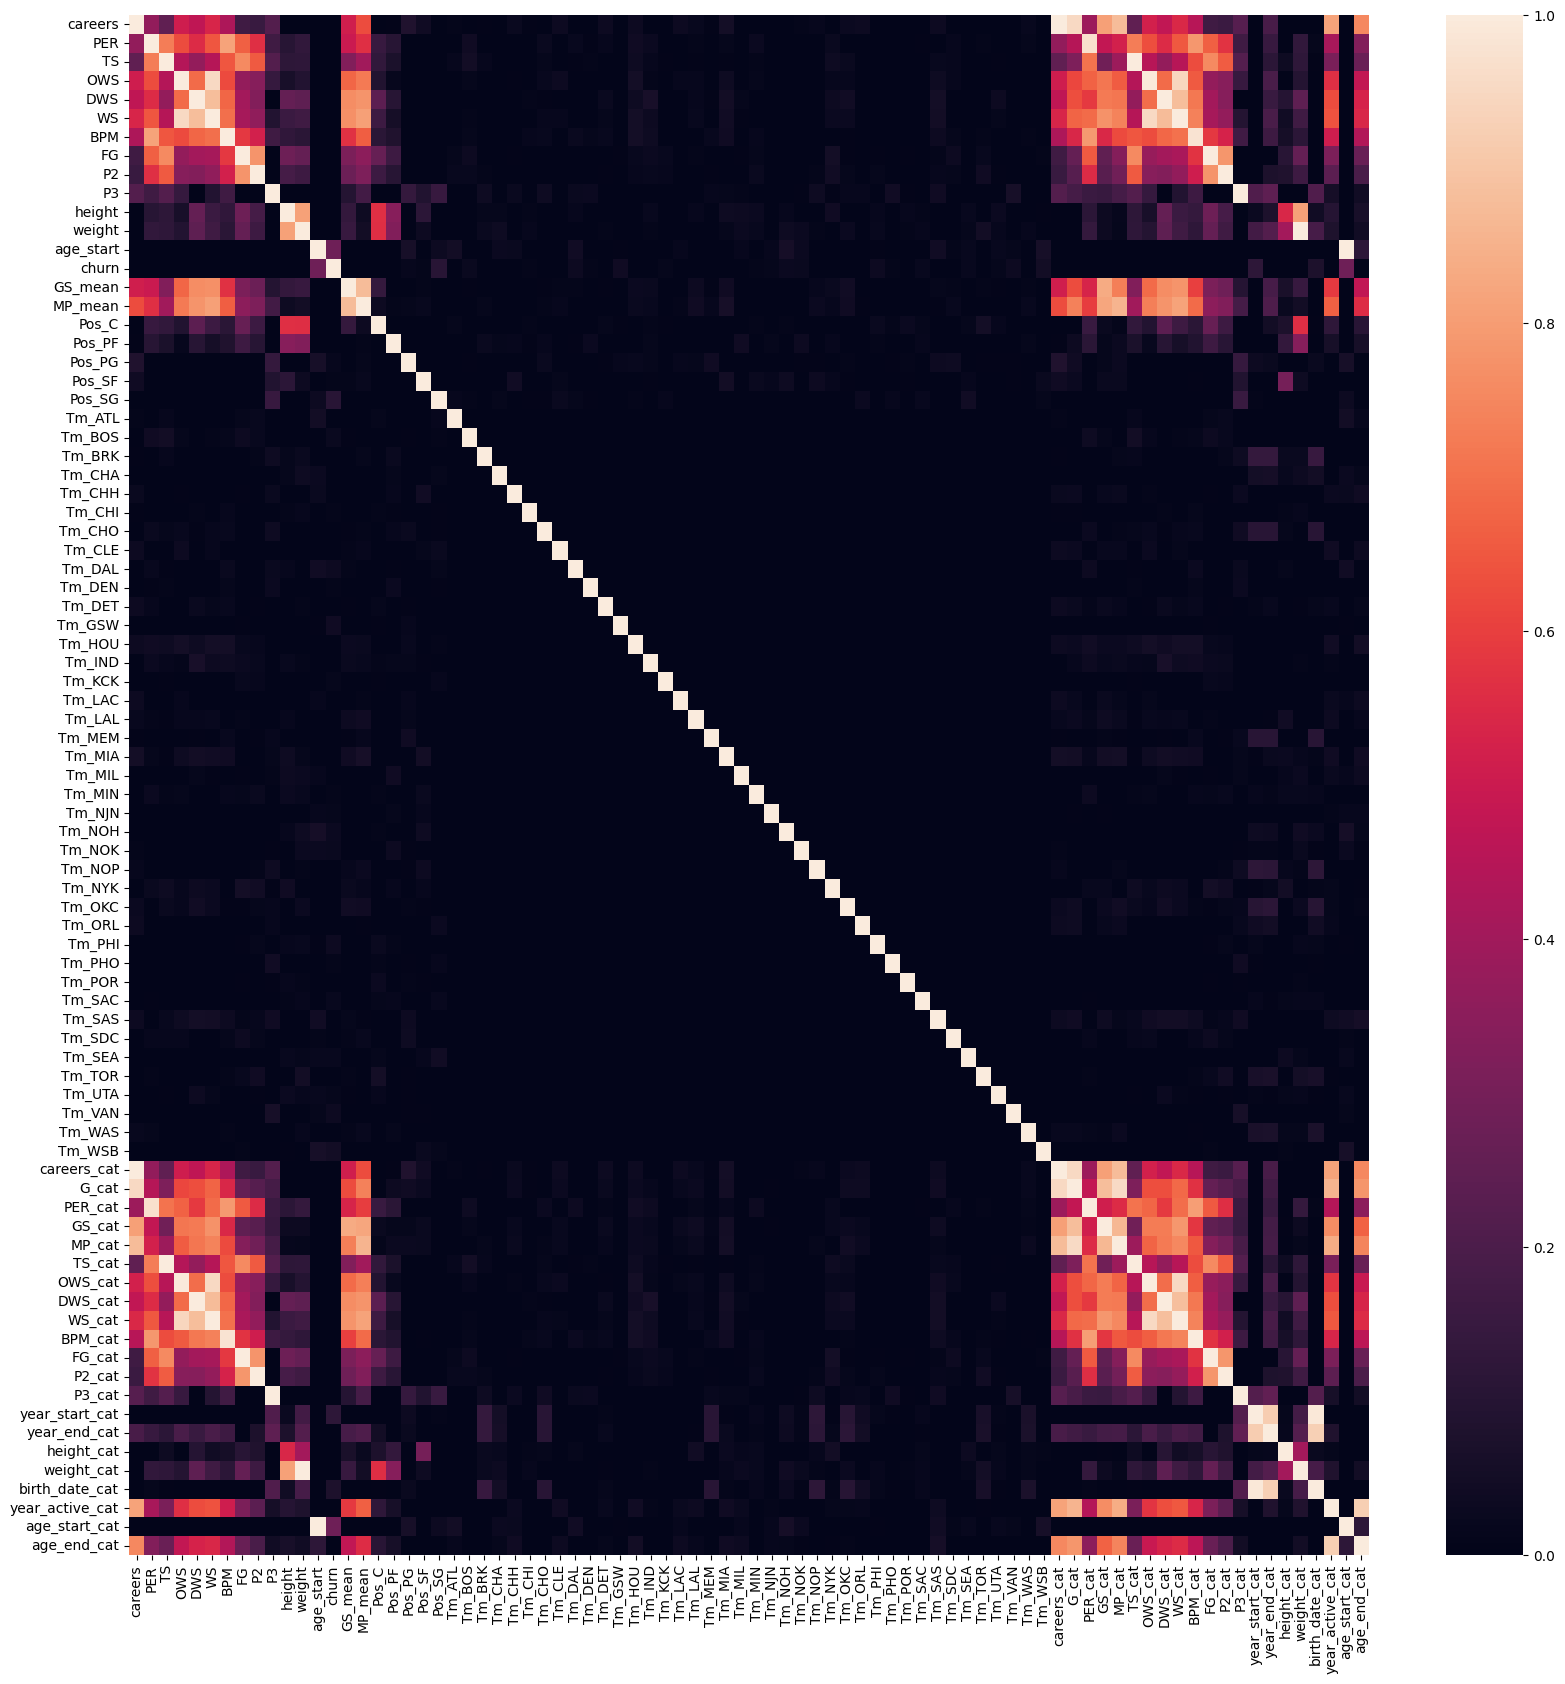

In [223]:
fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(df.corr(), vmin=0, ax=ax) # Desenha um mapa de calor (heatmap) da matriz de correlação do dataframe 'df'
plt.show() # Exibe o gráfico

In [224]:
# Seleciona um subconjunto de colunas do dataframe 'df' e armazena no novo dataframe 'data'.
data = df[[
    'careers', 'PER', 'TS', 'OWS', 'DWS', 'WS', 'BPM', 'FG', 'P2', 'P3',
       'height', 'weight', 'age_start', 'GS_mean', 'MP_mean', 'Pos_PF',
       'Pos_SG', 'Pos_PG', 'Pos_C', 'Pos_SF', 'Tm_MIA', 'Tm_WSB', 'Tm_GSW',
       'Tm_DAL', 'Tm_PHO', 'Tm_BOS', 'Tm_IND', 'Tm_ORL', 'Tm_SAC', 'Tm_CHO',
       'Tm_LAL', 'Tm_LAC', 'Tm_TOR', 'Tm_DEN', 'Tm_MIL', 'Tm_PHI', 'Tm_MIN',
       'Tm_NJN', 'Tm_CHI', 'Tm_WAS', 'Tm_POR', 'Tm_DET', 'Tm_UTA', 'Tm_OKC',
       'Tm_NYK', 'Tm_NOH', 'Tm_ATL', 'Tm_NOP', 'Tm_SAS', 'Tm_HOU', 'Tm_CLE',
       'Tm_BRK', 'Tm_SEA', 'Tm_MEM', 'Tm_CHH', 'Tm_VAN', 'Tm_SDC', 'Tm_NOK',
       'Tm_CHA', 'Tm_KCK']]
label = df['churn'] # Seleciona a coluna 'churn' do dataframe 'df' e a armazena na variável 'label'.

In [225]:
data2 = df.loc['careers':'Tm_WSB']
df.shape


(2294, 84)

In [226]:
df.head()

,careers,Pos,Tm,PER,TS,OWS,DWS,WS,BPM,FG,...,P2_cat,P3_cat,year_start_cat,year_end_cat,height_cat,weight_cat,birth_date_cat,year_active_cat,age_start_cat,age_end_cat
0,18,PF,MIA,13.9,0.5,3.4,2.4,5.8,-0.1,0.5,...,5,1,20,26,19,67,20,15,4,18
1,2,SG,WSB,11.6,0.5,-0.2,0.7,0.6,-5.1,0.4,...,5,1,25,17,13,22,24,1,5,5
2,3,PG,GSW,4.4,0.3,0.1,-0.0,0.1,-11.0,0.3,...,3,3,35,28,9,27,35,2,4,5
3,1,C,DAL,8.4,0.5,-0.2,0.2,0.0,-5.6,0.4,...,4,5,51,42,20,107,49,0,6,5
4,9,PG,PHO,10.4,0.4,0.1,0.4,0.6,-4.1,0.4,...,4,2,44,40,12,28,43,5,5,9


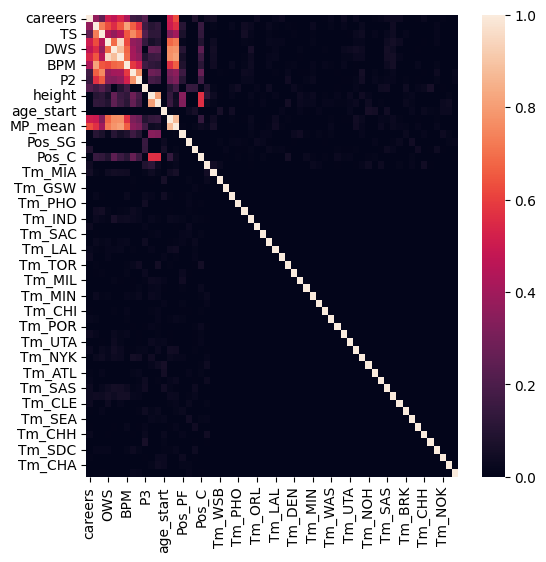

In [227]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(data.corr(), vmin=0, ax=ax) # Desenha um mapa de calor (heatmap) da matriz de correlação do dataframe 'df'

plt.savefig('data_corr_heatmap.png')

In [228]:
x_train, x_valid, y_train, y_valid = train_test_split(data, label, test_size=0.3) # Utiliza a função 'train_test_split' para dividir o dataset em conjuntos de treinamento e validação.

In [229]:
modelLR = LogisticRegression() # Inicializa um modelo de Regressão Logística.
modelLR.fit(x_train, y_train) # Treina o modelo de Regressão Logística usando os conjuntos de treinamento x_train e y_train.

modelRF = RandomForestClassifier() # Inicializa um modelo de Floresta Aleatória (Random Forest).
modelRF.fit(x_train, y_train) # Treina o modelo de Floresta Aleatória usando os conjuntos de treinamento x_train e y_train.

modelGB = GradientBoostingClassifier() # Inicializa um modelo de Gradient Boosting.
modelGB.fit(x_train, y_train) # Treina o modelo de Gradient Boosting usando os conjuntos de treinamento x_train e y_train.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GradientBoostingClassifier()

In [230]:
predictLR = modelLR.predict(x_valid) # Usa o modelo de Regressão Logística treinado para fazer previsões no conjunto de validação.
print('Logistic Regression: \n', classification_report(predictLR, y_valid))
print('Logistic Regression Accuracy: ', accuracy_score(predictLR, y_valid))

predictRF = modelRF.predict(x_valid) # Usa o modelo de Floresta Aleatória treinado para fazer previsões no conjunto de validação.
print('Random Forest Classifier : \n', classification_report(predictRF, y_valid))
print('Random Forest Classifier Accuracy: ', accuracy_score(predictRF, y_valid))

predictGB = modelGB.predict(x_valid) # Usa o modelo de Gradient Boosting treinado para fazer previsões no conjunto de validação.
print('Gradient Boost Classifier : \n', classification_report(predictGB, y_valid))
print('Gradient Boost Classifier Accuracy: ', accuracy_score(predictGB, y_valid))

Logistic Regression: 
               precision    recall  f1-score   support

           0       0.83      0.87      0.85       356
           1       0.85      0.80      0.83       333

    accuracy                           0.84       689
   macro avg       0.84      0.84      0.84       689
weighted avg       0.84      0.84      0.84       689

Logistic Regression Accuracy:  0.8388969521044993
Random Forest Classifier : 
               precision    recall  f1-score   support

           0       0.83      0.86      0.85       363
           1       0.84      0.81      0.83       326

    accuracy                           0.84       689
   macro avg       0.84      0.84      0.84       689
weighted avg       0.84      0.84      0.84       689

Random Forest Classifier Accuracy:  0.8374455732946299
Gradient Boost Classifier : 
               precision    recall  f1-score   support

           0       0.82      0.89      0.86       347
           1       0.88      0.81      0.84       

In [231]:
# Calcula e imprime o log-loss para as previsões feitas pelo modelo de Regressão Logística.
print('Log-loss LR model: ', log_loss(y_pred=predictLR, y_true=y_valid))
print('Log-loss RF model: ', log_loss(y_pred=predictRF, y_true=y_valid))
print('Log-loss GB model: ', log_loss(y_pred=predictGB, y_true=y_valid))
print('Log-loss 0 model: ', log_loss(y_pred=[0 for i in range(len(y_valid))], y_true=y_valid))

Log-loss LR model:  5.806742418275767
Log-loss RF model:  5.8590554130350085
Log-loss GB model:  5.44055145496108
Log-loss 0 model:  16.426280354401722


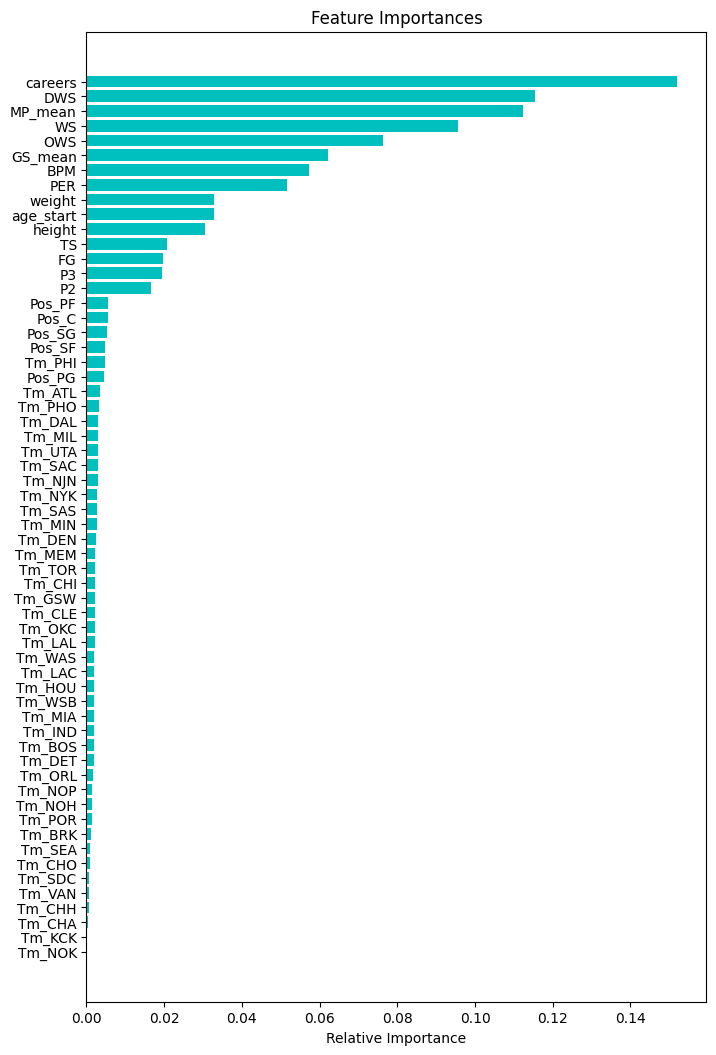

In [232]:
features = data.columns
importances = modelRF.feature_importances_
indices = np.argsort(importances)

# Ajuste o tamanho da figura. O primeiro número é a largura, o segundo é a altura.
plt.figure(figsize=(8, len(indices) * 0.21))

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='c', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()